In [1]:
###############################
# Import the necessary modules
###############################

# The PyBullet physics simulation library
import pybullet as pb
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt

In [2]:
#################################################################
# Forward and Inverse kinematics modules for the serial-2R robot
#################################################################

def forward_kinematics(theta1, theta2, l1, l2):
    '''
    Forward kinematics module for a serial-2R chain.
    The base of the manipulator is assumed to be placed at the
    coordinates [0,0].
    All the joints allow rotation about the positive Z-axis.
    Args:
    --- theta1: Angle between the link l1 and the positive x-axis (in radians)
    --- theta2: Relative angle between link l1 and link l2 (in radians)
    --- l1: Length of link l1 (in m)
    --- l2: Length of link l2 (in m)
    Ret:
    --- [x, y]: Position co-ordinates of the end-effector (in m)
    '''
    x = l1*math.cos(theta1) + l2*math.cos(theta1 + theta2)
    y = l1*math.sin(theta1) + l2*math.sin(theta1 + theta2)
    return [x, y]

def inverse_kinematics(x, y, l1, l2, branch=1):
    '''
    Inverse kinematics modules for the serial-2R manipulator.
    The base of the manipulator is placed at [0,0].
    Axis of rotation is the Z+ axis.
    Args:
    --- x : X co-ordinate of the end-effector
    --- y : Y co-ordinate of the end-effector
    --- l1: Length of link l1
    --- l2: Length of link l2
    --- branch: Branch of the inverse kinematics solution.
    Ret:
    --- valid: Binary variable indicating if the solution is valid or not
    --- [theta1, theta2]: Angles made by link l1 w.r.t X+ axis and the relative
                    angle between links l1 and l2 respectively.
    '''
    a = 2*x*l2
    b = 2*y*l2
    c =  l1*l1 - x*x - y*y  - l2*l2 
    psi = math.atan2(b, a)
    d = -c/math.sqrt(a*a + b*b)
    
    if (d < -1) or (d > 1):
        print("Position out of workspace.")
        return False, [0,0]
    if branch == 1:
        theta12 = psi + math.acos(-c/math.sqrt(a*a + b*b))
    else:
        theta12 = psi - math.acos(-c/math.sqrt(a*a + b*b))
        
    theta1 = math.atan2((y - l2*math.sin(theta12))/l1, (x - l2*math.cos(theta12))/l1)
    return True, [theta1, theta12-theta1]

In [3]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = pb.connect(pb.GUI) # or p.GUI


# Load the URDF of the plane that forms the ground
pb.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = pb.loadURDF("plane.urdf")


# Load the URDF of the robot
scara = pb.loadURDF("scara_robot_left.urdf")

In [4]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
pb.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
pb.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
#p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [5]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
pb.setJointMotorControl2(scara, 1, pb.VELOCITY_CONTROL, force=0)
pb.setJointMotorControl2(scara, 2, pb.VELOCITY_CONTROL, force=0)

In [6]:
x=np.array([])
y=np.array([])
x=np.append(x,np.array([1]*50))
y=np.append(y,np.linspace(0,1,50))
x= np.append(x,np.linspace(1,-1,100))
y=np.append(y,np.array([1]*100))
x=np.append(x,np.array([-1]*100))
y=np.append(y,np.linspace(1,-1,100))
x=np.append(x,np.linspace(-1,1,100))
y=np.append(y,np.array([-1]*100))
x=np.append(x,np.array([1]*50))
y=np.append(y,np.linspace(-1,0,50))

#plt.figure()
#plt.scatter(x,y,s=1,alpha=0.5)

In [7]:
pos_actual=[]

In [8]:
 for i in range(400):
    pt_des = np.array([x[i],y[i]])

    valid, [theta1, theta2] = inverse_kinematics(pt_des[0], pt_des[1], 1, 1)
    if valid==False:
        break
    dt     = 0.0001 # simulation time-step
    p_gain = 2000 # Proportional gain
    d_gain = 10 # Derivative gain
    error  = 0
    error_old = 0
    desired_pos = np.array([theta1, theta2])
    for _ in range(1000):
        pos1, _, _, _ = pb.getJointState(scara,1)
        pos2, _, _, _ = pb.getJointState(scara,2)
        pos = np.array([pos1, pos2])
        error_old = error
        error = desired_pos - pos
        error_d = (error - error_old)/dt
        control_force = p_gain * error + d_gain * error_d
        control_force = np.clip(control_force, -500, 500)
        pb.setJointMotorControlArray(scara, [1,2], pb.TORQUE_CONTROL, forces=control_force)
        pb.stepSimulation()
    # Check if the robot has reached the desired position
    pos1, _, _, _ = pb.getJointState(scara, 1)
    pos2, _, _, _ = pb.getJointState(scara, 2)
    pt_act = forward_kinematics(pos1, pos2, 1, 1)
    pos_actual.append(pt_act)
    print(pt_des)
    print(pt_act)

[1. 0.]
[1.0000000038019563, -1.9223485026031994e-09]
[1.         0.02040816]
[0.999999999998344, 0.02040816326609962]
[1.         0.04081633]
[0.9999999999983151, 0.040816326531378455]
[1.         0.06122449]
[0.9999999999982889, 0.06122448979665607]
[1.         0.08163265]
[0.9999999999982643, 0.0816326530619329]
[1.         0.10204082]
[0.9999999999982431, 0.10204081632720863]
[1.         0.12244898]
[0.9999999999982243, 0.12244897959248369]
[1.         0.14285714]
[0.9999999999989391, 0.1428571428575065]
[1.         0.16326531]
[1.000000000000305, 0.16326530612234824]
[1.         0.18367347]
[1.0000000000016807, 0.1836734693872415]
[1.         0.20408163]
[1.000000000003062, 0.2040816326521856]
[1.        0.2244898]
[1.0000000000040878, 0.22448979591727436]
[1.         0.24489796]
[1.0000000000032334, 0.2448979591828665]
[1.         0.26530612]
[1.0000000000023788, 0.26530612244842666]
[1.         0.28571429]
[1.0000000000015272, 0.2857142857139555]
[1.         0.30612245]
[1.00000

[-0.5959596  1.       ]
[-0.5959595959598254, 0.999999999989732]
[-0.61616162  1.        ]
[-0.6161616161617668, 0.9999999999890244]
[-0.63636364  1.        ]
[-0.6363636363637013, 0.999999999988324]
[-0.65656566  1.        ]
[-0.6565656565656299, 0.9999999999876298]
[-0.67676768  1.        ]
[-0.6767676767675536, 0.999999999986942]
[-0.6969697  1.       ]
[-0.6969696969694736, 0.9999999999862592]
[-0.71717172  1.        ]
[-0.7171717171713909, 0.9999999999855818]
[-0.73737374  1.        ]
[-0.737373737373306, 0.9999999999849083]
[-0.75757576  1.        ]
[-0.7575757575752203, 0.9999999999842373]
[-0.77777778  1.        ]
[-0.7777777777771343, 0.9999999999835689]
[-0.7979798  1.       ]
[-0.7979797979790492, 0.9999999999829017]
[-0.81818182  1.        ]
[-0.8181818181809659, 0.9999999999822342]
[-0.83838384  1.        ]
[-0.8383838383828843, 0.9999999999815655]
[-0.85858586  1.        ]
[-0.8585858585848067, 0.9999999999808947]
[-0.87878788  1.        ]
[-0.8787878787867321, 0.99999999

[-0.95959596 -1.        ]
[-0.959595959618379, -1.0000000000023916]
[-0.93939394 -1.        ]
[-0.9393939394156674, -1.0000000000027605]
[-0.91919192 -1.        ]
[-0.9191919192129604, -1.0000000000031037]
[-0.8989899 -1.       ]
[-0.8989898990102554, -1.000000000003422]
[-0.87878788 -1.        ]
[-0.8787878788075527, -1.000000000003716]
[-0.85858586 -1.        ]
[-0.8585858586048526, -1.0000000000039855]
[-0.83838384 -1.        ]
[-0.8383838384021537, -1.0000000000042308]
[-0.81818182 -1.        ]
[-0.8181818181994565, -1.0000000000044513]
[-0.7979798 -1.       ]
[-0.7979797979967591, -1.0000000000046485]
[-0.77777778 -1.        ]
[-0.7777777777940638, -1.00000000000482]
[-0.75757576 -1.        ]
[-0.757575757591368, -1.0000000000049676]
[-0.73737374 -1.        ]
[-0.737373737388582, -1.0000000000050602]
[-0.71717172 -1.        ]
[-0.717171717185765, -1.0000000000051132]
[-0.6969697 -1.       ]
[-0.6969696969829513, -1.0000000000051332]
[-0.67676768 -1.        ]
[-0.6767676767801365, 

[ 1.         -0.44897959]
[1.000000000002857, -0.4489795918406725]
[ 1.         -0.42857143]
[1.0000000000024296, -0.42857142857462927]
[ 1.         -0.40816327]
[1.0000000000019662, -0.4081632653085985]
[ 1.        -0.3877551]
[1.0000000000014666, -0.38775510204258334]
[ 1.         -0.36734694]
[1.0000000000009313, -0.36734693877658353]
[ 1.         -0.34693878]
[1.0000000000003604, -0.3469387755106025]
[ 1.         -0.32653061]
[0.9999999999997541, -0.3265306122446404]
[ 1.         -0.30612245]
[0.9999999999991138, -0.30612244897869856]
[ 1.         -0.28571429]
[0.9999999999984396, -0.28571428571277957]
[ 1.         -0.26530612]
[0.9999999999977326, -0.26530612244688456]
[ 1.         -0.24489796]
[0.9999999999969936, -0.24489795918101476]
[ 1.        -0.2244898]
[0.9999999999962234, -0.22448979591517193]
[ 1.         -0.20408163]
[0.9999999999954241, -0.20408163264935786]
[ 1.         -0.18367347]
[0.9999999999961431, -0.18367346938477047]
[ 1.         -0.16326531]
[0.99999999999719

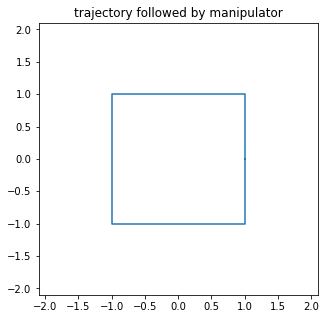

In [10]:
pos_actual=np.array(pos_actual)
plt.figure(figsize=(5,5))
plt.xlim(-2.1,2.1)
plt.ylim(-2.1,2.1)
plt.title('trajectory followed by manipulator')
plt.plot(pos_actual[:,0],pos_actual[:,1])
#plt.plot(x1,x2)